<a href="https://colab.research.google.com/github/Mercurylonely/APP-PERPUS/blob/main/Evaluasi_Kerja_Murid_Fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-fuzzy pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
import matplotlib.pyplot as plt

# Membaca dataset
data = pd.read_csv('study_performance.csv')

In [ ]:
data.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [ ]:
# Normalisasi data untuk memastikan semua skor berada dalam rentang 0-100
def normalize(column):
    return (column - column.min()) / (column.max() - column.min()) * 100

data['math_score'] = normalize(data['math_score'])
data['reading_score'] = normalize(data['reading_score'])
data['writing_score'] = normalize(data['writing_score'])

In [ ]:
# Membuat variabel fuzzy untuk Math, Reading, dan Writing Scores
math_score = ctrl.Antecedent(np.arange(0, 101, 1), 'math_score')
reading_score = ctrl.Antecedent(np.arange(0, 101, 1), 'reading_score')
writing_score = ctrl.Antecedent(np.arange(0, 101, 1), 'writing_score')
performance = ctrl.Consequent(np.arange(0, 101, 1), 'performance')

In [ ]:
# Menentukan fungsi keanggotaan untuk setiap variabel
math_score['low'] = fuzz.trapmf(math_score.universe, [0, 0, 40, 60])
math_score['medium'] = fuzz.trimf(math_score.universe, [40, 60, 80])
math_score['high'] = fuzz.trapmf(math_score.universe, [60, 80, 100, 100])

reading_score['low'] = fuzz.trapmf(reading_score.universe, [0, 0, 40, 60])
reading_score['medium'] = fuzz.trimf(reading_score.universe, [40, 60, 80])
reading_score['high'] = fuzz.trapmf(reading_score.universe, [60, 80, 100, 100])

writing_score['low'] = fuzz.trapmf(writing_score.universe, [0, 0, 40, 60])
writing_score['medium'] = fuzz.trimf(writing_score.universe, [40, 60, 80])
writing_score['high'] = fuzz.trapmf(writing_score.universe, [60, 80, 100, 100])

performance['poor'] = fuzz.trapmf(performance.universe, [0, 0, 40, 60])
performance['average'] = fuzz.trimf(performance.universe, [40, 60, 80])
performance['excellent'] = fuzz.trapmf(performance.universe, [60, 80, 100, 100])

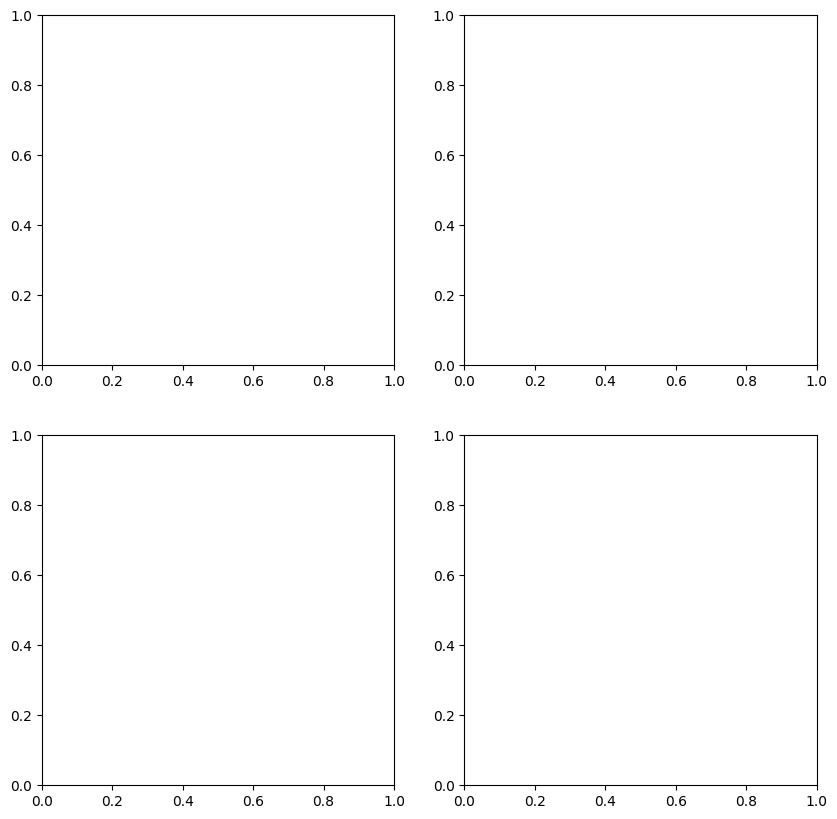

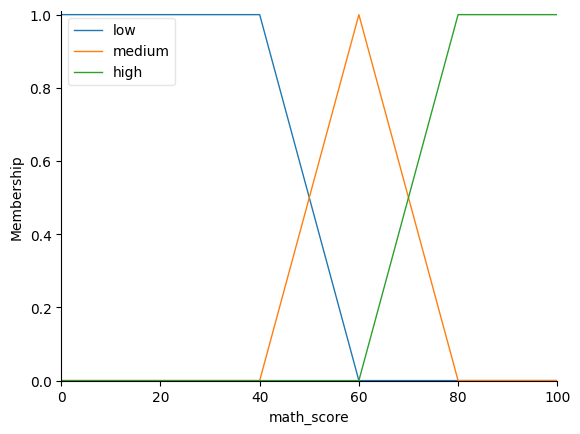

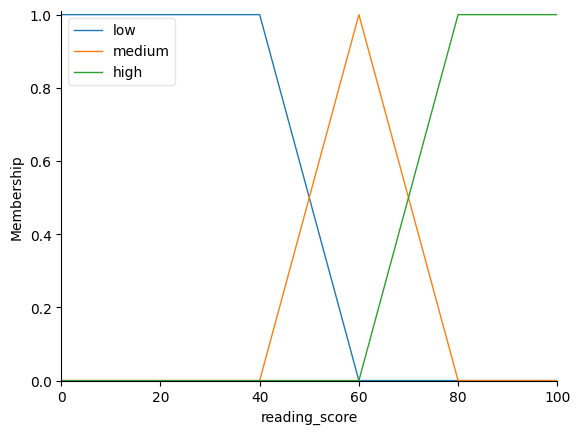

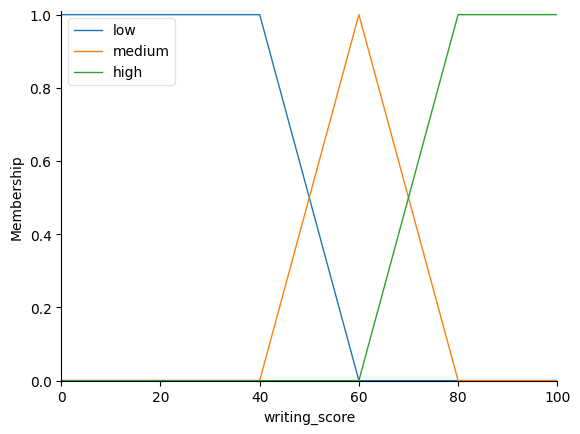

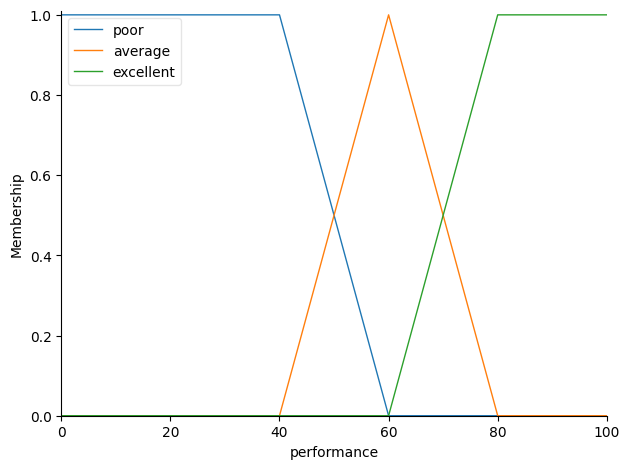

In [ ]:
# Visualisasi fungsi keanggotaan
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
math_score.view(ax=axs[0, 0])
reading_score.view(ax=axs[0, 1])
writing_score.view(ax=axs[1, 0])
performance.view(ax=axs[1, 1])
plt.tight_layout()
plt.show()

In [ ]:
# Menentukan aturan fuzzy (rules)
rules = [
    ctrl.Rule(math_score['high'] & reading_score['high'] & writing_score['high'], performance['excellent']),
    ctrl.Rule(math_score['medium'] & reading_score['medium'] & writing_score['medium'], performance['average']),
    ctrl.Rule(math_score['low'] | reading_score['low'] | writing_score['low'], performance['poor']),
    ctrl.Rule(math_score['high'] & (reading_score['medium'] | writing_score['medium']), performance['average']),
    ctrl.Rule(math_score['low'] & reading_score['high'] & writing_score['high'], performance['average'])
]

In [ ]:
# Membuat sistem kontrol fuzzy
performance_ctrl = ctrl.ControlSystem(rules)
performance_sim = ctrl.ControlSystemSimulation(performance_ctrl)

In [ ]:
# Mengevaluasi setiap siswa
def evaluate_performance(row):
    performance_sim.input['math_score'] = row['math_score']
    performance_sim.input['reading_score'] = row['reading_score']
    performance_sim.input['writing_score'] = row['writing_score']

    performance_sim.compute()
    return performance_sim.output['performance']

data['Performance'] = data.apply(evaluate_performance, axis=1)


In [ ]:
# Menambahkan kategori kinerja berdasarkan skor
bins = [0, 40, 70, 100]
labels = ['Poor', 'Average', 'Excellent']
data['Performance Category'] = pd.cut(data['Performance'], bins=bins, labels=labels)

In [ ]:
# Menampilkan hasil
data[['math_score', 'reading_score', 'writing_score', 'Performance', 'Performance Category']].to_csv('student_performance_results.csv', index=False)


In [ ]:
data_hasil = pd.read_csv('student_performance_results.csv')

In [ ]:
data_hasil.head()

,math_score,reading_score,writing_score,Performance,Performance Category
0,72.0,66.265060,71.111111,68.548186,Average
1,69.0,87.951807,86.666667,82.154930,Excellent
2,90.0,93.975904,92.222222,84.444444,Excellent
3,47.0,48.192771,37.777778,25.333333,Poor
4,76.0,73.493976,72.222222,74.957753,Excellent


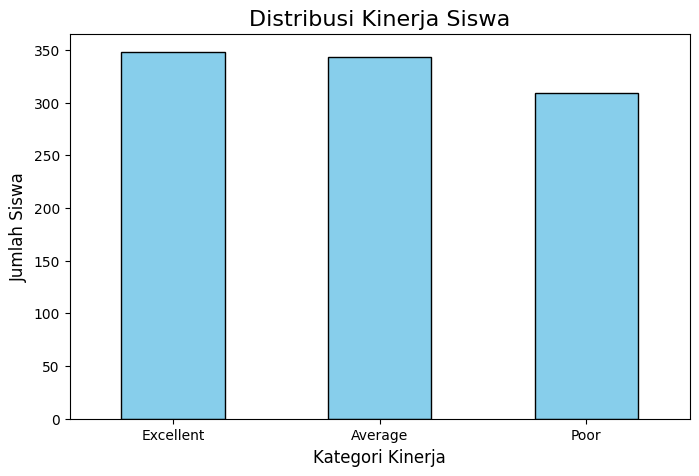

In [ ]:
# Visualisasi hasil distribusi kinerja
plt.figure(figsize=(8, 5))
data['Performance Category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribusi Kinerja Siswa', fontsize=16)
plt.xlabel('Kategori Kinerja', fontsize=12)
plt.ylabel('Jumlah Siswa', fontsize=12)
plt.xticks(rotation=0)
plt.show()